### Introduction
This notebook explores the use of knn, random forest, and multilayer perceptron neural networks for performing multilabel classification on chess positions. It seeks to identify the tactical and positional motifs from the first and second position of two move chess puzzles from the lichess.org database.

In [13]:
import chess
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from helpers import count_moves, make_array, col_to_set, clean_labels, get_model

In [42]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import hamming_loss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MultiLabelBinarizer


In [15]:
sns.set_theme()

In [16]:
# Load initial lichess puzzle database
col_names = ['PuzzleId', 'FEN', 'Moves', 'Rating', 'RatingDeviation', 'Popularity', 'NbPlays', 'Themes', 'GameUrl']
df = pd.read_csv('data/lichess_db_puzzle.csv', names=col_names)
df = df.drop(['PuzzleId', 'Rating', 'RatingDeviation', 'Popularity', 'NbPlays', 'GameUrl'], axis=1)

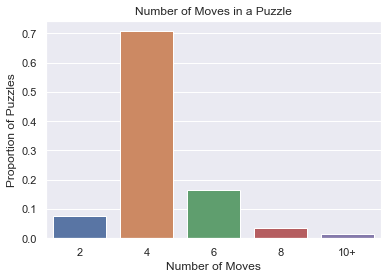

In [17]:
df['move_count'] = df.apply(lambda row: count_moves(row), axis=1)
df['turns'] = df['move_count'] / 2
gb = df.groupby(['turns'])['move_count'].count()
gb = pd.DataFrame(gb)
gb['bin'] = gb.index.values
gb['bin'] = np.where(gb.bin > 5, 5, gb.bin)
gb = gb.groupby(['bin']).sum('move_count')
sns.barplot(x=gb.index.values, y=gb.move_count/np.sum(gb.move_count))
plt.ylabel('Proportion of Puzzles')
plt.xlabel('Number of Moves')
plt.title('Number of Moves in a Puzzle')
locs, curr_labels = plt.xticks()
plt.xticks(locs, ['2' , '4', '6', '8', '10+'])
plt.show()

In [18]:
# Limit to two move puzzles
df = df[df.move_count == 2]

In [19]:
data = []
row = 0
df_moves = df.Moves
df_themes = np.array(df.Themes)
df_fen = np.array(df.FEN)
for move_string in df_moves:
    move_list = move_string.split(' ')

    #### FIRST MOVE
    board = chess.Board(df_fen[row])
    board.push_san(move_list[0])
    color = board.turn
    if color == False:
        mirror_board = board.mirror()
        f1 = mirror_board.fen()
    else:
        f1 = board.fen()

    #### SECOND MOVE
    board.push_san(move_list[1])
    color = board.turn
    if color == False:
        mirror_board = board.mirror()
        f2 = mirror_board.fen()
    else:
        f2 = board.fen()
    record = (row, f1, f2, df_themes[row])
    data.append(record)
    row += 1

In [20]:
final_df = pd.DataFrame(data, columns=['id', 'fen1', 'fen2', 'themes'])

Some motifs are calculated by an engine, and others are not frequent enough in the two-move subset.

In [21]:
drop_list = ['advantage', 'crushing', 'equality', 'long', 'masterVsMaster', 'master', 'mateIn1', 'mateIn2', 'mateIn3', 'mateIn4', 'mateIn5', 'short', 'superGM', 'oneMove', 'veryLong', 'xrayattack', 'clearance', 'interference', 'attraction', 'intermezzo', 'sacrifice', 'skewer', 'capturingdefender', 'deflection', 'quietmove', 'exposedking', 'trappedpiece', 'underpromotion', 'zugzwang', 'castling', 'fork', 'bodenmate', 'enpassant', 'doublebishopmate', 'anastasiamate', 'dovetailmate', 'arabianmate', 'doublecheck', 'knightendgame', 'bishopendgame', 'pawnendgame', 'hookmate','promotion', 'discoveredattack']
drop_list = [s.lower() for s in drop_list]

In [22]:
final_df.themes = final_df.apply(lambda row: clean_labels(row["themes"], drop_list), axis=1)

In [23]:
df_themes = final_df.themes
theme_list = set()
for row in df_themes:
    row_list = row.split(' ')
    theme_list.update(row_list)
theme_list = list(theme_list)
print("Transforming column of themes into set...")
themes_split = df_themes.apply(lambda row: col_to_set(row))#, axis=1)
print("Themes column transformed.")

print("Creating Multi Labels...")
mlb = MultiLabelBinarizer(classes=theme_list)
indicators = mlb.fit_transform(themes_split)
print(indicators.shape)
indicator_classes = mlb.classes
print(indicator_classes)
print("Multilabels Complete.")

Transforming column of themes into set...
Themes column transformed.
Creating Multi Labels...
(120426, 16)
['rookendgame', 'opening', 'middlegame', 'queenrookendgame', 'queensideattack', 'endgame', 'advancedpawn', 'kingsideattack', 'hangingpiece', 'defensivemove', 'backrankmate', 'smotheredmate', 'attackingf2f7', 'queenendgame', 'mate', 'pin']
Multilabels Complete.


In [24]:
letters = "ABCDEFGH"
numbers = "12345678"
names1 = []
for n in numbers:
    for l in letters:
        name = l + n
        names1.append(name)

letters2 = "ijklmnop"
names2 = []
for n in numbers:
    for l in letters2:
        name = l + n
        names2.append(name)

In [25]:
piece_dict = {
    '.': 0,
    'P': 1,
    'N': 2,
    'B': 3,
    'R': 4,
    'Q': 5,
    'K': 6,
    'p': -1,
    'n': -2,
    'b': -3,
    'r': -4,
    'q': -5,
    'k': -6
}

In [26]:
final_df.head()

,id,fen1,fen2,themes
0,0,8/8/kp6/p4pQp/q7/7P/3r2P1/4R2K w - - 0 49,4r2k/3q2p1/7p/Q7/P4P1P/KP6/8/8 w - - 0 49,endgame hangingpiece
1,1,r2r2k1/2q1bpp1/3p3p/1ppn4/1P1BP3/P5Q1/4RPPP/R5...,r5k1/4rppp/p7/1p1bp3/1PPN4/3P3P/2Q1BPq1/R2R2K1...,kingsideattack mate middlegame
2,2,2q3k1/4br2/6pQ/1p1n2p1/7P/1P4P1/1B2PP2/6K1 w -...,6k1/1b2pp2/1p4p1/7p/1P1N2P1/6P1/4BR2/2Q3Kq w -...,endgame mate
3,3,8/8/2p5/1p1p1k2/3P4/1PP1pK2/8/8 w - - 4 65,8/8/2p1Pk2/1p1p4/1P1P1K2/2P5/8/8 w - - 0 65,defensivemove endgame
4,4,8/2p5/1p3Qrk/p2P2r1/P1P4p/7P/6PK/8 w - - 12 58,8/6pk/7p/p1p4P/P2p2R1/1P4RK/2P5/7q w - - 13 59,endgame mate queenrookendgame


In [27]:
final_df["board_list1"] = final_df.apply(lambda row: make_array(row['fen1'], piece_dict), axis=1)
final_df["board_list2"] = final_df.apply(lambda row: make_array(row['fen2'], piece_dict), axis=1)
final_df[names1] = pd.DataFrame(final_df.board_list1.tolist(), index=final_df.index)
final_df[names2] = pd.DataFrame(final_df.board_list2.tolist(), index=final_df.index)

In [28]:
final_df.columns

Index(['id', 'fen1', 'fen2', 'themes', 'board_list1', 'board_list2', 'A1',
       'B1', 'C1', 'D1',
       ...
       'o7', 'p7', 'i8', 'j8', 'k8', 'l8', 'm8', 'n8', 'o8', 'p8'],
      dtype='object', length=134)

In [29]:
final_df = final_df.drop(["id", "board_list1", "board_list2", "fen1", "fen2", "themes"], axis=1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(final_df, indicators, test_size=0.3, random_state=888)

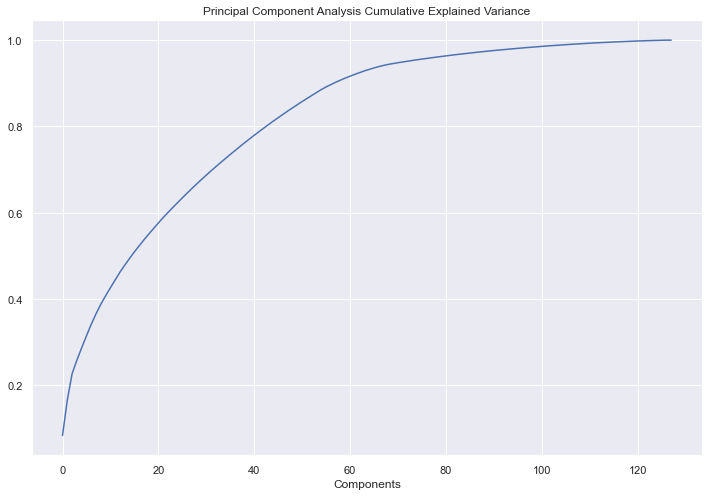

In [31]:
plt.rcParams["figure.figsize"] = (12, 8)
pca = PCA()
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.title('Principal Component Analysis Cumulative Explained Variance');

In [32]:
pca = PCA(n_components=70)
X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)

In [33]:
param_grid = {'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform', 'distance']}
scoring = 'f1_weighted'
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train_transformed, y_train)
grid.best_params_

{'n_neighbors': 9, 'weights': 'distance'}

In [36]:
param_grid = {'n_estimators': [50, 100, 150, 200, 250],
              'min_samples_split': [20, 30, 40]}
scoring = 'f1_weighted'
forest_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
forest_grid.fit(X_train_transformed, y_train)
forest_grid.best_params_

{'min_samples_split': 20, 'n_estimators': 250}

In [38]:
param_grid = {'hidden_layer_sizes': [(128,), (256,), (128, 64), (256, 128)]}
scoring = 'f1_weighted'
mlp_grid = GridSearchCV(MLPClassifier(activation='relu', max_iter=1000, random_state=74), param_grid, cv=5)
mlp_grid.fit(X_train_transformed, y_train)
mlp_grid.best_params_

{'hidden_layer_sizes': (128,)}

In [44]:
# Predict with best knn parameters
knn_predictions = grid.best_estimator_.predict(X_test_transformed)
print(f1_score(y_test, knn_predictions, average='weighted'))
print(f1_score(y_test, knn_predictions, average='micro'))
print(hamming_loss(y_test, knn_predictions))

0.702394324078929
0.7230862394471557
0.06724182074844996


In [45]:
# Predict with best random forest parameters
rforest_predictions = forest_grid.best_estimator_.predict(X_test_transformed)
print(f1_score(y_test, rforest_predictions, average='weighted'))
print(f1_score(y_test, rforest_predictions, average='micro'))
print(hamming_loss(y_test, rforest_predictions))

0.7252421751402477
0.7779245474735451
0.052933320416297606


In [46]:
# Predict with best mlp parameters
mlp_predictions = mlp_grid.best_estimator_.predict(X_test_transformed)
print(f1_score(y_test, mlp_predictions, average='weighted'))
print(f1_score(y_test, mlp_predictions, average='micro'))
print(hamming_loss(y_test, mlp_predictions))

0.8105949249162846
0.831758034026465
0.04172490865810452


In [47]:
performance_data = []
for i in range(16):
    score1 = f1_score(y_test[:, i], mlp_predictions[:, i])
    score2 = f1_score(y_test[:, i], rforest_predictions[:, i])
    score3 = f1_score(y_test[:, i], knn_predictions[:, i])
    performance_data.append({'theme': theme_list[i], 'NeuralNetwork': score1, 'KNN': score2, 'RandomForest': score3})

In [49]:
performance_df = pd.DataFrame.from_records(performance_data)
performance_df = performance_df.sort_values('theme')
performance_df

,theme,NeuralNetwork,KNN,RandomForest
6,advancedpawn,0.016575,0.000000,0.081841
12,attackingf2f7,0.943713,0.754237,0.757426
10,backrankmate,0.739705,0.229987,0.478156
9,defensivemove,0.000000,0.000000,0.012526
5,endgame,0.891623,0.847057,0.805027
8,hangingpiece,0.487122,0.174621,0.400957
7,kingsideattack,0.769185,0.660294,0.487625
14,mate,0.918572,0.885335,0.847542
2,middlegame,0.885714,0.850969,0.734012
1,opening,0.819190,0.689617,0.740226
